In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils_qiskit import find_pauli_indices
from utils import hamiltonian_to_matrix
from algo.utils_qiskit import process_hamiltonian_Zs

# This hamiltionian has two ground states
the ground energy is -5 with muliplicity 2

In [2]:
ham_str = "-3.0 + 0.5 * Z0 + 0.25 * Z1 + 0.25 * Z2 + 0.5 * Z3 + 0.75 * Z0*Z2 - 0.25 * Z1*Z2 + 0.25 * Z0*Z1 + 0.25 * Z0*Z3 + 0.75 * Z1*Z3 + 0.25 * Z2*Z3 - 0.25 * Z0*Z1*Z2 - 0.25 * Z1*Z2*Z3"
num_q = 4  # Number of qubits
max_stars = 3  # Maximum number of stars to categorize terms (e.g., 0-star, 1-star, 2-star, 3-star)

# Call the function to process the Hamiltonian string
all_lists, all_coeffs = process_hamiltonian_Zs(ham_str, num_q, max_stars)

# Output the results for each star category
for i, (term_positions, term_coeffs) in enumerate(zip(all_lists, all_coeffs)):
    print(f"Terms with {i} star(s):")
    print("Coefficients:", term_coeffs)
    print("Positions:", term_positions)

print('')

List_0, List_1, List_2, List_3 = all_lists
List = List_0 + List_1 + List_2 + List_3

coeff_0, coeff_1, coeff_2, coeff_3 = all_coeffs
coeff = coeff_0 + coeff_1 + coeff_2 + coeff_3

H = SparsePauliOp(List, coeff)
Hmat = Operator(H)
Hmat = Hmat.data

# CHECK IT IS THE SAME AS MATRIX FROM JAX PROBLEM
H2 = hamiltonian_to_matrix(ham_str)
print('difference between two matrices', np.linalg.norm(H2-Hmat.data))

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state (eigenvector)
ground_e = np.min(e) # ground state energy
print('ground state energy',ground_e)
print('hamiltonian strings size',H.size)
# print(H)
print(e)


Terms with 0 star(s):
Coefficients: [-3.0]
Positions: ['IIII']
Terms with 1 star(s):
Coefficients: [0.5, 0.25, 0.25, 0.5]
Positions: ['ZIII', 'IZII', 'IIZI', 'IIIZ']
Terms with 2 star(s):
Coefficients: [0.75, -0.25, 0.25, 0.25, 0.75, 0.25]
Positions: ['ZIZI', 'IZZI', 'ZZII', 'ZIIZ', 'IZIZ', 'IIZZ']
Terms with 3 star(s):
Coefficients: [-0.25, -0.25]
Positions: ['ZZZI', 'IZZZ']

difference between two matrices 0.0
ground state energy (-5+0j)
hamiltonian strings size 13
[ 0.+0.j -3.+0.j -1.+0.j -4.+0.j -1.+0.j -2.+0.j -5.+0.j -4.+0.j -3.+0.j
 -5.+0.j -2.+0.j -4.+0.j -4.+0.j -4.+0.j -4.+0.j -2.+0.j]


In [3]:
# Check the ground state
for x in np.linalg.eigh(Hmat)[1][:, :2].T:
    print(np.nonzero(x))
print(int('0110', 2), int('1001', 2))
E_gs = np.linalg.eigh(Hmat)[0][0]
print(E_gs)

(array([6], dtype=int64),)
(array([9], dtype=int64),)
6 9
-5.0


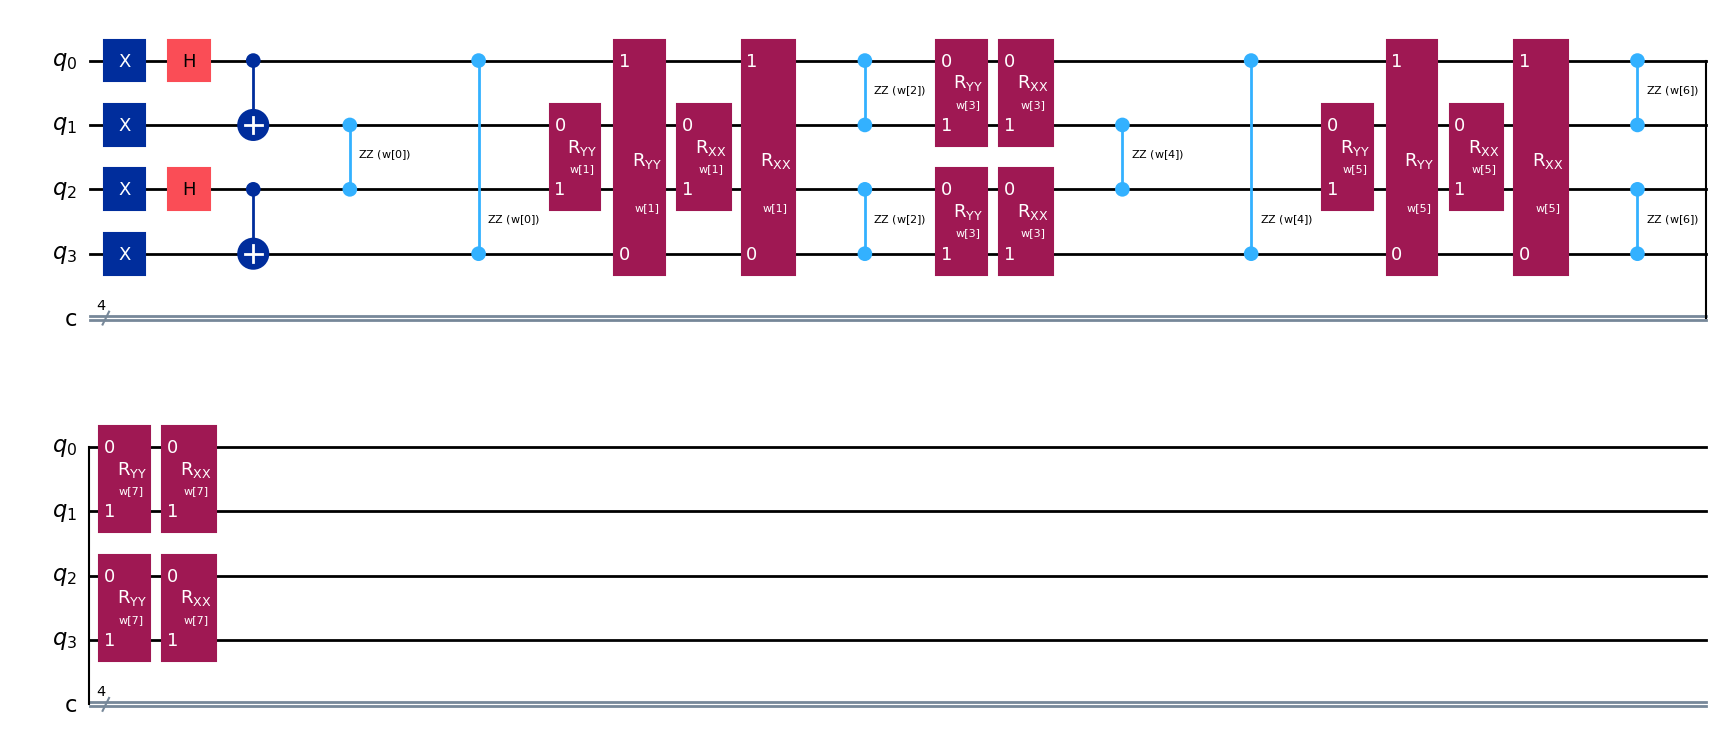

In [4]:
"""Circuit construction"""
layer = 2  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


In [5]:
simulator = AerSimulator()

Z_indices = []
ZZ_indices = []
ZZZ_indices = []

for pauli_str in List_1:
    # print(pauli_str)
    _, _, Z_index = find_pauli_indices(pauli_str)
    Z_indices.append(Z_index)

for pauli_str in List_2:
    # print(pauli_str)
    _, _, ZZ_index = find_pauli_indices(pauli_str)
    ZZ_indices.append(ZZ_index)

for pauli_str in List_3:
    # print(pauli_str)
    _, _, ZZZ_index = find_pauli_indices(pauli_str)
    ZZZ_indices.append(ZZZ_index)

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0 
    estimate_2 = 0
    estimate_3 = 0

    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)

    for i in range(SHOTS):
        c_i = c[i]

        # List_1 = ['ZIII'] Terms with 1 star
        for j, index in enumerate(Z_indices): 
            if c_i[num_q-1-index[0]] == '0':
                estimate_1 += 1*coeff_1[j]
            else:
                estimate_1 += -1*coeff_1[j]
        
        # List_2 = ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IIZZ'] Terms with 2 stars
        for j, index in enumerate(ZZ_indices): 
            if c_i[num_q-1-index[0]] == c_i[num_q-1-index[1]]:
                estimate_2 += 1*coeff_2[j]
            else:
                estimate_2 += -1*coeff_2[j]

        # List_3 = ['ZZZI', 'ZZIZ', 'IZZZ', 'IIZI', 'IZIZ', 'ZIZZ'] Terms with 3 stars
        for j, index in enumerate(ZZZ_indices): 
            num = [c_i[num_q-1-index[0]],c_i[num_q-1-index[1]],c_i[num_q-1-index[2]]].count('1')
            if num % 2 == 0:
                estimate_3 += 1*coeff_3[j]
            else:
                estimate_3 += -1*coeff_3[j]

    estimate = estimate_1 + estimate_2 + estimate_3
    estimate = estimate/SHOTS + coeff_0[0] # coeff_0[0] for 'IIII'

    return estimate



def expectation_loss(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2


def std(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))



In [6]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))
print(E_gs)

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    num_trials = 5000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=15, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


-3.801015903852282
1.0127609734042182
-3.7531224086131934
-5.0


In [7]:
from check_utils import interp_matrix

weights_dict = {}

omegas_1 = list(range(1, num_q // 2 + 1)) # [1, 2]
interp_nodes_1 = np.linspace(0,2*np.pi,2*len(omegas_1)+1,endpoint=False)
inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))

omegas_2 = list(range(1, (num_q // 2) * 2 + 1)) # [1, 2, 3, 4]
interp_nodes_2 = np.linspace(0,2*np.pi,2*len(omegas_2)+1,endpoint=False)
inverse_interp_matrix_2 = np.linalg.inv(interp_matrix(interp_nodes_2, omegas_2))

for j in range(num_p):
    if j % 2 == 0: 
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_1,
            'interp_nodes': interp_nodes_1,
            'inverse_interp_matrix': inverse_interp_matrix_1,
        }
    elif j % 2 == 1:  # even layers with RYY+RXX gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_2,
            'interp_nodes': interp_nodes_2,
            'inverse_interp_matrix': inverse_interp_matrix_2,
        }

print(weights_dict['weights_0'])
print(weights_dict['weights_1'])
print(f'true ground state energy:',ground_e)

{'omegas': [1, 2], 'interp_nodes': array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825]), 'inverse_interp_matrix': array([[ 2.82842712e-01,  2.82842712e-01,  2.82842712e-01,
         2.82842712e-01,  2.82842712e-01],
       [ 4.00000000e-01,  1.23606798e-01, -3.23606798e-01,
        -3.23606798e-01,  1.23606798e-01],
       [-9.44412113e-17,  3.80422607e-01,  2.35114101e-01,
        -2.35114101e-01, -3.80422607e-01],
       [ 4.00000000e-01, -3.23606798e-01,  1.23606798e-01,
         1.23606798e-01, -3.23606798e-01],
       [-1.00603272e-16,  2.35114101e-01, -3.80422607e-01,
         3.80422607e-01, -2.35114101e-01]])}
{'omegas': [1, 2, 3, 4], 'interp_nodes': array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361]), 'inverse_interp_matrix': array([[ 1.57134840e-01,  1.57134840e-01,  1.57134840e-01,
         1.57134840e-01,  1.57134840e-01,  1.57134840e-01,
         1.57134840e-01,  1.57134840e-01,  1.571348

In [8]:
# Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

from check_utils import check_is_trigometric  # Assuming check_is_trigometric is defined in check_utils module

# Define random weights
weights = np.random.normal(0, 4 * np.pi**2, num_p)

# Loop over each weight index and check trigonometric interpolation
for j in range(num_p):
    # Circuit_HEA is simple and all Hermitian generators are Y.
    omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
    print('\n index to check = ', j)
    print('omegas = ', omegas)
    
    opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
    # Call the function to check if the objective function can be interpolated using trigonometric interpolation
    check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)




 index to check =  0
omegas =  [1, 2]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-4.63285323e+00  2.17737383e-16 -1.79977262e-14 -4.92926566e-01
 -7.87648098e-01]

 index to check =  1
omegas =  [1, 2, 3, 4]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-4.86690666e+00  1.24087413e-11 -5.90945117e-12  8.70836409e-01
  6.38720680e-01  1.26428183e-11 -8.67250389e-12  1.72086639e-01
  2.41187651e-02]

 index to check =  2
omegas =  [1, 2]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-4.48627882e+00 -2.09127186e-14 -4.41608014e-15 -1.67518627e-01
 -6.77931756e-01]

 index to check =  3
omegas =  [1, 2, 3, 4]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [-5.29137936e+00 -1.12157062e-11 -2.67358856e-12 -2.48868566e-01
 -4.22977835e-01 -2.81140982e-12 -2.50502615e-12  4.35295712e-01
  3.87722799e-01]

 index to check =  4
omegas =  [1, 2]
Consistent results: 100/100
【All Passed】
Estimated coefficients:  [

In [9]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000


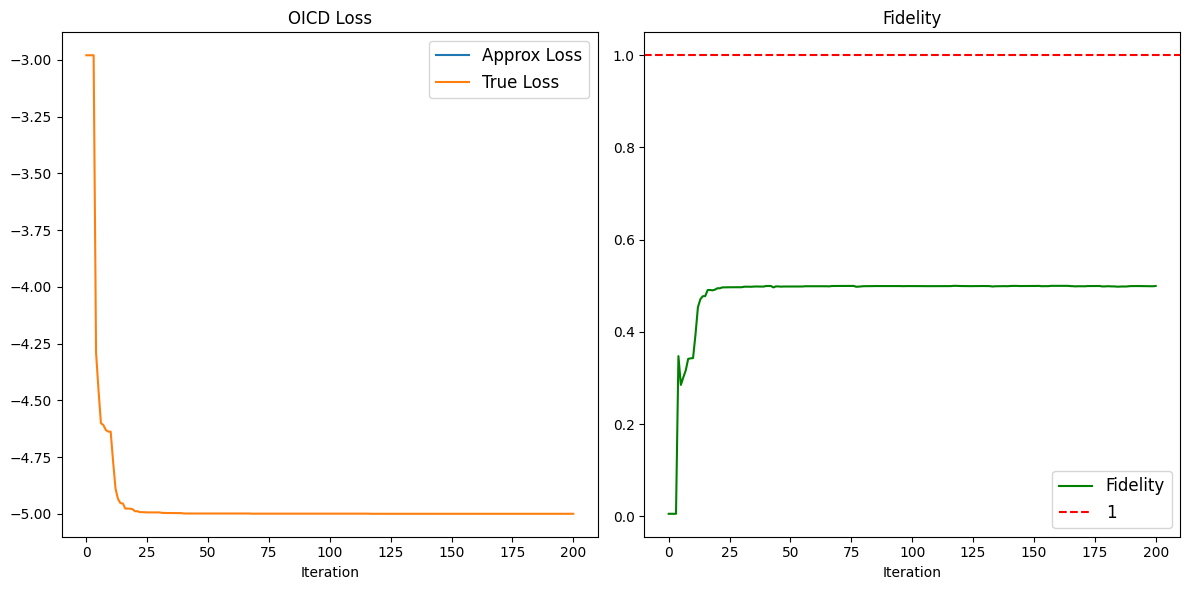

[OICD] Iter: 199 - Coord: 3(8), Best loss: -4.999894461314287, True loss: -4.998831267790245, Fidelity: 0.49964975175341886: 100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


In [10]:
# OICD Optimization
from algo.oicd_qiskit import oicd

num_iter = 200
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    subproblem_method='BFGS',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    subproblem_iter=None,
    cyclic_mode=False,
    use_local_solvers_flag=True, # It must be true, since omegas are not all 1
    use_pratical_interp_flag=True,
    exact_mode=False,
    plot_flag=True,
)


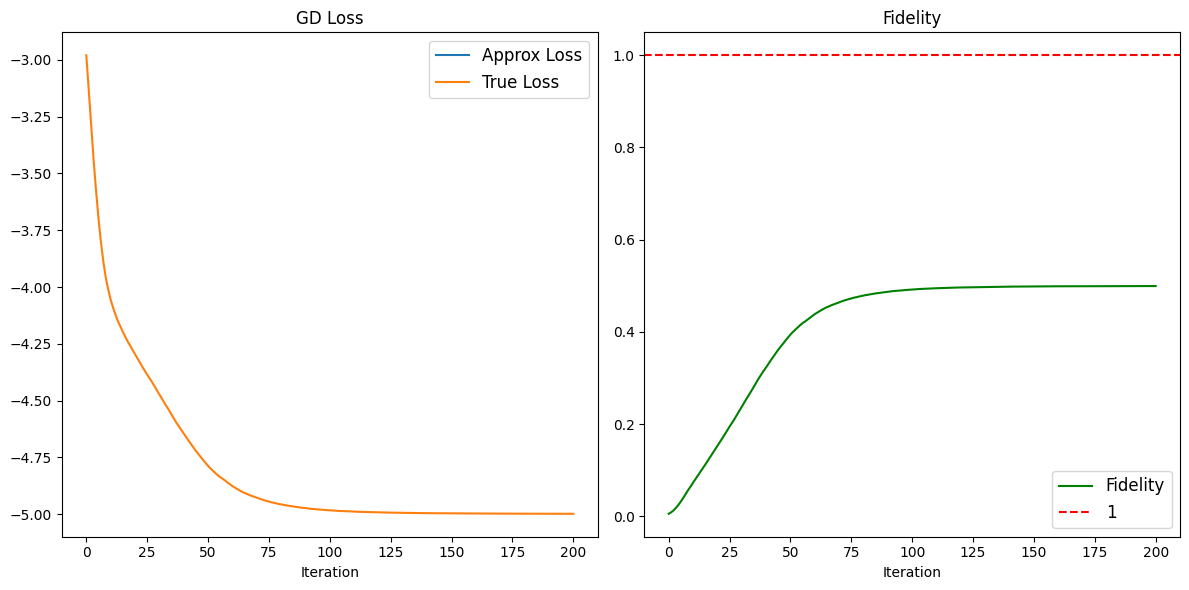

[GD] Iter: 199, Best loss: -4.998906596499544, True loss: -4.998818900341663, Fidelity: 0.4995185724924592: 100%|██████████| 200/200 [06:23<00:00,  1.92s/it]


In [11]:

# Gradient Descent Optimization
from algo.gd_qiskit import gd

num_iter = 200
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.01,
    exact_mode=False,
    plot_flag=True,
)


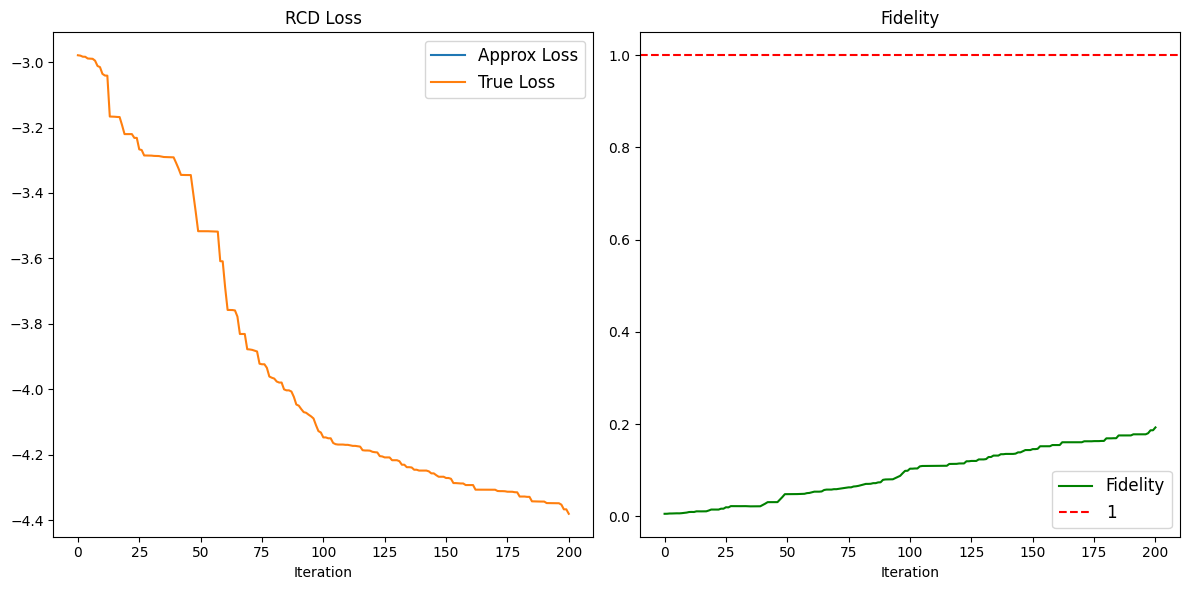

[RCD] Iter: 199, Best loss: -4.379897895190386, True loss: -4.379897895190386, Fidelity: 0.19291314481511132: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


In [12]:

# RCD Optimization
from algo.rcd_qiskit import rcd

num_iter = 200
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd= rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.01,
    cyclic_mode=False,
    exact_mode=False,
    plot_flag=True,
)


c:\ProgramData\anaconda3\envs\RCD\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


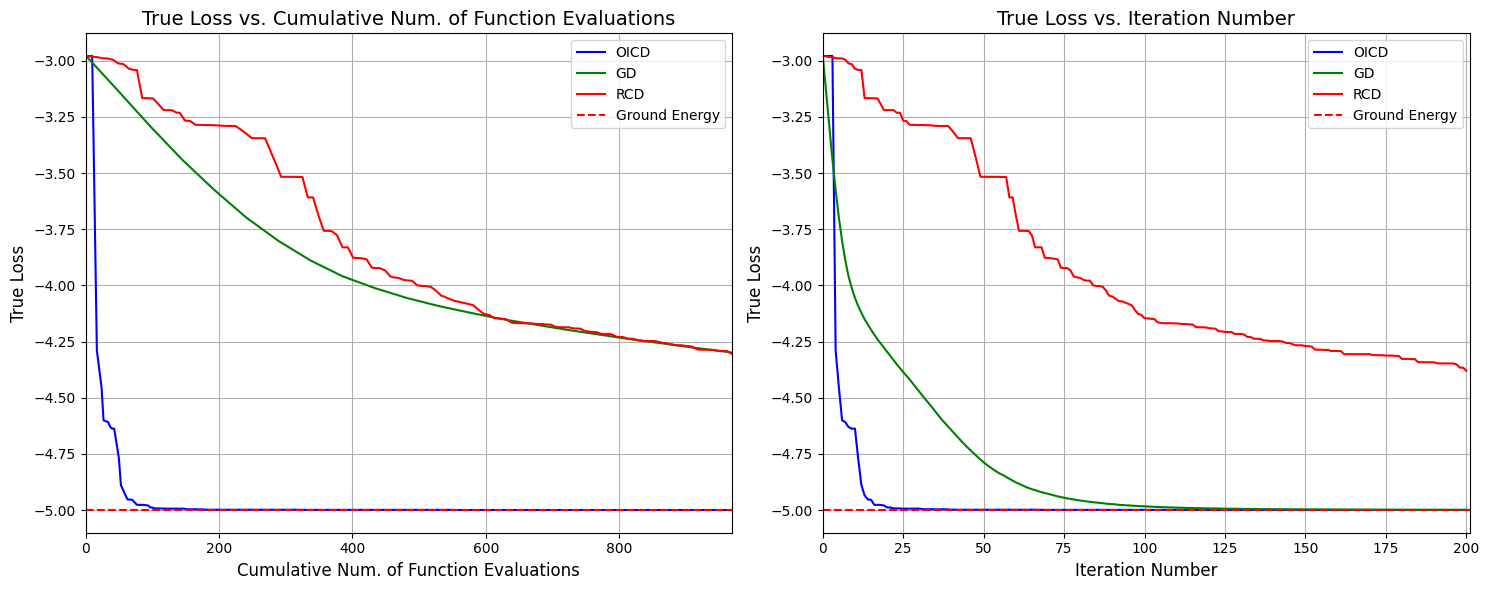

In [13]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()
